In [1]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, UpSampling2D, Conv2D, Concatenate, Input
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import plot_model
from keras.applications import VGG16
from keras.models import Model

import matplotlib.pyplot as plt

%matplotlib inline

im_size = 256

Using TensorFlow backend.


In [2]:
total_data = pd.read_csv('data/metadata.csv')

print('Number of examples is',total_data.shape[0])
num_classes = 120

train_data, val_data = train_test_split(total_data, test_size=0.1, random_state=1)

Number of examples is 6572


In [3]:
def load_imgs(ids, inputstr='data/train/{}_{:02d}.jpg'):
    imgs = []
    
    for idx in ids:
        for i in range(16):
            img = cv2.imread(inputstr.format(idx, i+1))
            if img is not None:
                # print('--->', inputstr.format(idx, i+1))
                img = cv2.resize(img, (im_size, im_size))
                imgs.append(img)
    
    return np.array(imgs)

In [4]:
def load_and_process_data(data):
    
    data_imgs = load_imgs(data['id'], 'data/train/{}_{:02d}.jpg')
    data_imgs = data_imgs / 255.0
    data_masks = np.expand_dims(load_imgs(data['id'], 'data/train_masks/{}_{:02d}_mask.jpg').mean(axis=3), axis=3)
    data_masks = data_masks / 255.0
    return (data_imgs, data_masks)

In [5]:
aa = load_and_process_data(total_data[:100])
print(aa[1].max())

1.0


In [6]:
def find_accuracy(X, Y, model):
    pred_classes = model.predict_classes(X, verbose=0, batch_size = 20)
    actual_classes = np.argmax(Y, axis=1)
    return np.sum(pred_classes == actual_classes)

In [7]:
def validation_accuracy(model):
    s = 0
    l = 0
    val_imgs, val_labels = load_and_process_data(val_data)
    predicted = model.predict(val_imgs, verbose=1)
    predicted = np.argmax(predicted, axis=1)
    actual = [dict_dogs[x] for x in val_data['breed']]

    for i in range(len(predicted)):
        l = l+1
        if predicted[i] == actual[i]:
            s = s+1
    return(s/l)

In [8]:
def run_training(num_samples, num_iter, train_data, model, batch_size = None, epochs = None):
    if batch_size is None:
        batch_size = 32
    if epochs is None:
        epochs = 1
    acc_vs_epoch = []
    for niter in range(num_iter):
        for i in range( int(float(len(train_data)) / float(num_samples) + 1.0)):
            print('Loading data from', i*num_samples, 'to', (i+1)*num_samples)
            train_imgs, train_labels = load_and_process_data(train_data [ i*num_samples: (i+1)*num_samples ])
            print(train_imgs.shape, train_labels.shape)
            model.fit(train_imgs, train_labels, epochs=epochs, batch_size=batch_size, verbose=1)
        #val_acc = validation_accuracy(model)
        #acc_vs_epoch.append(val_acc)
        #print('Validation Accuracy:', val_acc)
        
    return acc_vs_epoch

In [ ]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))
model2 = model_vgg.output
#model2 = MaxPooling2D(pool_size=(2,2))(model2)
model2 = Convolution2D(256, 3, 3, border_mode='same', init='glorot_uniform', activation='relu')(model2)
model2 = UpSampling2D(size = (2, 2))(model2)
model2 = Convolution2D(64, 3, 3, border_mode='same', init='glorot_uniform', activation='relu')(model2)
model2 = UpSampling2D(size = (2, 2))(model2)
model2 = Convolution2D(32, 3, 3, border_mode='same', init='glorot_uniform', activation='relu')(model2)
model2 = UpSampling2D(size = (2, 2))(model2)
model2 = Convolution2D(16, 3, 3, border_mode='same', init='glorot_uniform', activation='relu')(model2)
model2 = UpSampling2D(size = (2, 2))(model2)
model2 = Convolution2D(8, 3, 3, border_mode='same', init='glorot_uniform', activation='relu')(model2)
model2 = UpSampling2D(size = (2, 2))(model2)
model2 = Convolution2D(1, 3, 3, border_mode='same', init='glorot_uniform', activation='sigmoid')(model2)
model2 = Model(inputs=model_vgg.input, outputs=model2)

for layer in model_vgg.layers:
    layer.trainable = False
model2.compile(loss="binary_crossentropy", optimizer="rmsprop")
model2.summary()

In [ ]:
run_training(1001, 10, train_data[:1000], model3)

In [ ]:
#img, mask = load_and_process_data(train_data[:100])
i = 10
print(img.shape, mask[0, :, :, 0].shape)
plt.imshow(mask[i, :, :, 0])
plt.figure()
plt.imshow(img[i, :, :, :])
plt.figure()

outimage = model3.predict(img[i:i+1, :, :, :])
plt.imshow(outimage[0, :, :, 0])

In [ ]:
model2.save_weights('vgg_model.h5')

In [ ]:
model3 = Sequential()
model3.add(Convolution2D(4, 3, 3, border_mode='same', input_shape=(im_size, im_size, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(Convolution2D(4, 3, 3, border_mode='same', activation='relu'))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(Convolution2D(1, 3, 3, border_mode='same', activation='sigmoid'))

model3.compile(loss="binary_crossentropy", optimizer="adagrad")
model3.summary()

In [9]:
def down_layer(input_layer, num_filter):
    layer = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(input_layer)
    layer = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(layer)
    maxpool_layer = MaxPooling2D((2, 2))(layer)
    return maxpool_layer, layer

def up_layer(input_layer_down, input_layer_side, num_filter):
    layer = UpSampling2D(size=(2, 2))(input_layer_down)
    layer = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(layer)
    layer = Concatenate(axis=3)([input_layer_side, layer])
    layer = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(layer)
    layer = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(layer)
    
    return layer

input_layer = Input([im_size, im_size, 3])

down1, cross1 = down_layer(input_layer, 8)
down2, cross2 = down_layer(down1, 16)
down3, cross3 = down_layer(down2, 32)
down4, cross4 = down_layer(down3, 64)
_, cross5 = down_layer(down4, 128)


up1 = up_layer(cross5, cross4, 64)
up2 = up_layer(up1, cross3, 32)
up3 = up_layer(up2, cross2, 16)
up4 = up_layer(up3, cross1, 8)

out = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(up4)

unet_model = Model(input_layer, out)
unet_model.compile(loss="binary_crossentropy", optimizer="adagrad")

unet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
__________

In [32]:
run_training(1024, 1, train_data, unet_model, batch_size=32, epochs = 3)

Loading data from 0 to 1024
(848, 256, 256, 3) (848, 256, 256, 1)
Epoch 1/3
848/848 [==============================] - 29s - loss: 0.0275    
Epoch 2/3
848/848 [==============================] - 29s - loss: 0.0268    
Epoch 3/3
848/848 [==============================] - 29s - loss: 0.0264    
Loading data from 1024 to 2048
(736, 256, 256, 3) (736, 256, 256, 1)
Epoch 1/3
736/736 [==============================] - 25s - loss: 0.0282    
Epoch 2/3
736/736 [==============================] - 25s - loss: 0.0238    
Epoch 3/3
736/736 [==============================] - 25s - loss: 0.0230    
Loading data from 2048 to 3072
(752, 256, 256, 3) (752, 256, 256, 1)
Epoch 1/3
752/752 [==============================] - 26s - loss: 0.0238    
Epoch 2/3
752/752 [==============================] - 26s - loss: 0.0232    
Epoch 3/3
752/752 [==============================] - 26s - loss: 0.0237    
Loading data from 3072 to 4096
(736, 256, 256, 3) (736, 256, 256, 1)
Epoch 1/3
736/736 [========================

[]

(80, 256, 256, 3) (256, 256)


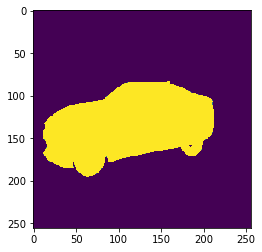

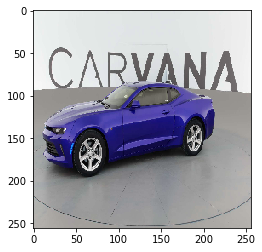

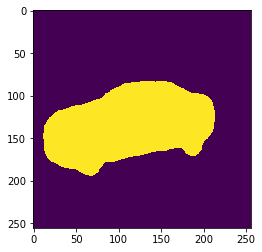

In [37]:
img, mask = load_and_process_data(train_data[:100])
i = 3
print(img.shape, mask[0, :, :, 0].shape)
plt.imshow(mask[i, :, :, 0])
plt.figure()
plt.imshow(img[i, :, :, :])
plt.figure()

outimage = unet_model.predict(img[i:i+1, :, :, :])
plt.imshow(outimage[0, :, :, 0]>0.5)

In [39]:
unet_model.save('unet2.dat')
unet_model.save_weights('unet2_weights.dat')

(256, 256, 3)


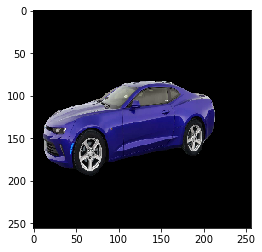

In [38]:
ii = img[i:i+1, :, :, :].reshape(256, 256, 3)
for c in range(3):
    ii[:, :, c] = ii[:, :, c]*(outimage[0, :, :, 0]>0.5)
print(ii.shape)
plt.imshow(ii)

In [35]:
def dice_coeff(img1, img2):
    a1 = img1.reshape(-1)
    a2 = img2.reshape(-1)
    
    return (2*np.sum(a1*a2)) / (a1.sum() + a2.sum())
    

In [36]:
val_imgs, val_masks = load_and_process_data(val_data)
val_predicted = unet_model.predict(val_imgs)

print(dice_coeff(val_masks, val_predicted))

0.969477976434
